# RNAseq data analysis

### Standard imports

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_curve, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
import scipy
import random
import collections
import csv

***Import Data***

In [2]:
df_counts_tpm = pd.read_csv('data/gene_expression/MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv', index_col=False)
df_counts = pd.read_csv('data/gene_expression/MMRF_CoMMpass_IA9_E74GTF_Salmon_Gene_Counts.txt', delimiter = "\t")
df_clin = pd.read_csv('data/clinical/sc3_Training_ClinAnnotations.csv')

# Rename Gene ID column 
df_counts_tpm = df_counts_tpm.rename(columns = {'Unnamed: 0':'Entrez_ID'})

df_counts.shape, df_counts_tpm.shape, df_clin.shape

((57997, 735), (24128, 735), (583, 44))

In [3]:
print("We have {} genes in the raw counts gene expression matrix".format(df_counts['GENE_ID'].unique().shape[0]))
print("We have {} genes in the raw counts gene expression matrix".format(df_counts_tpm['Entrez_ID'].unique().shape[0]))

We have 57997 genes in the raw counts gene expression matrix
We have 24128 genes in the raw counts gene expression matrix


In [4]:
print("N° of patients in the MMRF cohort, with RNAseq available RNA-seq data: {}".format(df_counts.shape[1]))
print("N° of patients in the MMRF cohort, with RNAseq available TPM-normalized RNA-seq data: {}".format(df_counts_tpm.shape[1]))

N° of patients in the MMRF cohort, with RNAseq available RNA-seq data: 735
N° of patients in the MMRF cohort, with RNAseq available TPM-normalized RNA-seq data: 735


**Uniformize patient ids**

In [5]:
df_clin['Patient'] += '_1_BM'
df_clin

,Study,Patient,D_Age,D_Gender,D_OS,D_OS_FLAG,D_PFS,D_PFS_FLAG,D_ISS,PatientType,...,CYTO_predicted_feature_10,CYTO_predicted_feature_11,CYTO_predicted_feature_12,CYTO_predicted_feature_13,CYTO_predicted_feature_14,CYTO_predicted_feature_15,CYTO_predicted_feature_16,CYTO_predicted_feature_17,CYTO_predicted_feature_18,HR_FLAG
0,MMRF,MMRF_1021_1_BM,54,Female,1575,0,623,1,1.0,NewlyDiagnosed,...,0.0,NaN,0,0,0,0,0,0,0,FALSE
1,MMRF,MMRF_1029_1_BM,46,Male,995,0,995,0,1.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,0,0,0,0,FALSE
2,MMRF,MMRF_1030_1_BM,65,Female,1572,0,1572,0,1.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,1,0,0,0,FALSE
3,MMRF,MMRF_1031_1_BM,62,Male,1581,0,1329,1,1.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,0,0,0,0,FALSE
4,MMRF,MMRF_1032_1_BM,76,Male,934,1,908,1,2.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,0,0,0,0,FALSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,MMRF,MMRF_2608_1_BM,67,Male,335,0,335,0,1.0,NewlyDiagnosed,...,0.0,NaN,0,0,0,0,1,0,0,CENSORED
579,MMRF,MMRF_2611_1_BM,66,Female,247,0,246,0,2.0,NewlyDiagnosed,...,NaN,NaN,0,1,0,0,0,1,0,CENSORED
580,MMRF,MMRF_2613_1_BM,70,Female,253,0,253,0,2.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,0,0,0,0,CENSORED
581,MMRF,MMRF_2614_1_BM,58,Male,290,0,290,0,1.0,NewlyDiagnosed,...,NaN,NaN,1,0,0,0,1,0,0,CENSORED


**Intersection of clinical and RNA-seq data**

In [6]:
clinical_patients = list(df_clin['Patient'].values)
seq_patients = list(df_counts_tpm.drop(['Entrez_ID'], axis=1).columns)
seq_patients2 = list(df_counts.drop(['GENE_ID'], axis=1).columns)

# Find intersection
common_patients = list(set(seq_patients) & set(clinical_patients) & set(seq_patients2))
                    
print("Number of patients with clinical and sequencing data: {}".format(len(common_patients)))

Number of patients with clinical and sequencing data: 582


**Select common patients from gene expression matrix**

In [7]:
df_counts = df_counts.loc[:, ['GENE_ID'] + common_patients]
df_counts_tpm = df_counts_tpm.loc[:, ['Entrez_ID'] + common_patients]
df_clin = df_clin[df_clin['Patient'].isin(common_patients)]

df_counts.shape, df_counts_tpm.shape, df_clin.shape

((57997, 583), (24128, 583), (582, 44))

**We only keep non-CENSORED patients for the gene selection**

In [8]:
# .
df_clin = df_clin[df_clin['HR_FLAG'] != "CENSORED"]
df_counts_tpm = df_counts_tpm.loc[:, ['Entrez_ID'] + list(df_clin['Patient'])]
df_counts = df_counts.loc[:, ['GENE_ID'] + list(df_clin['Patient'])]

df_counts_tpm.shape, df_counts.shape, df_clin.shape

((24128, 392), (57997, 392), (391, 44))

### Exploratory graphical analysis

**Gene Density plots**

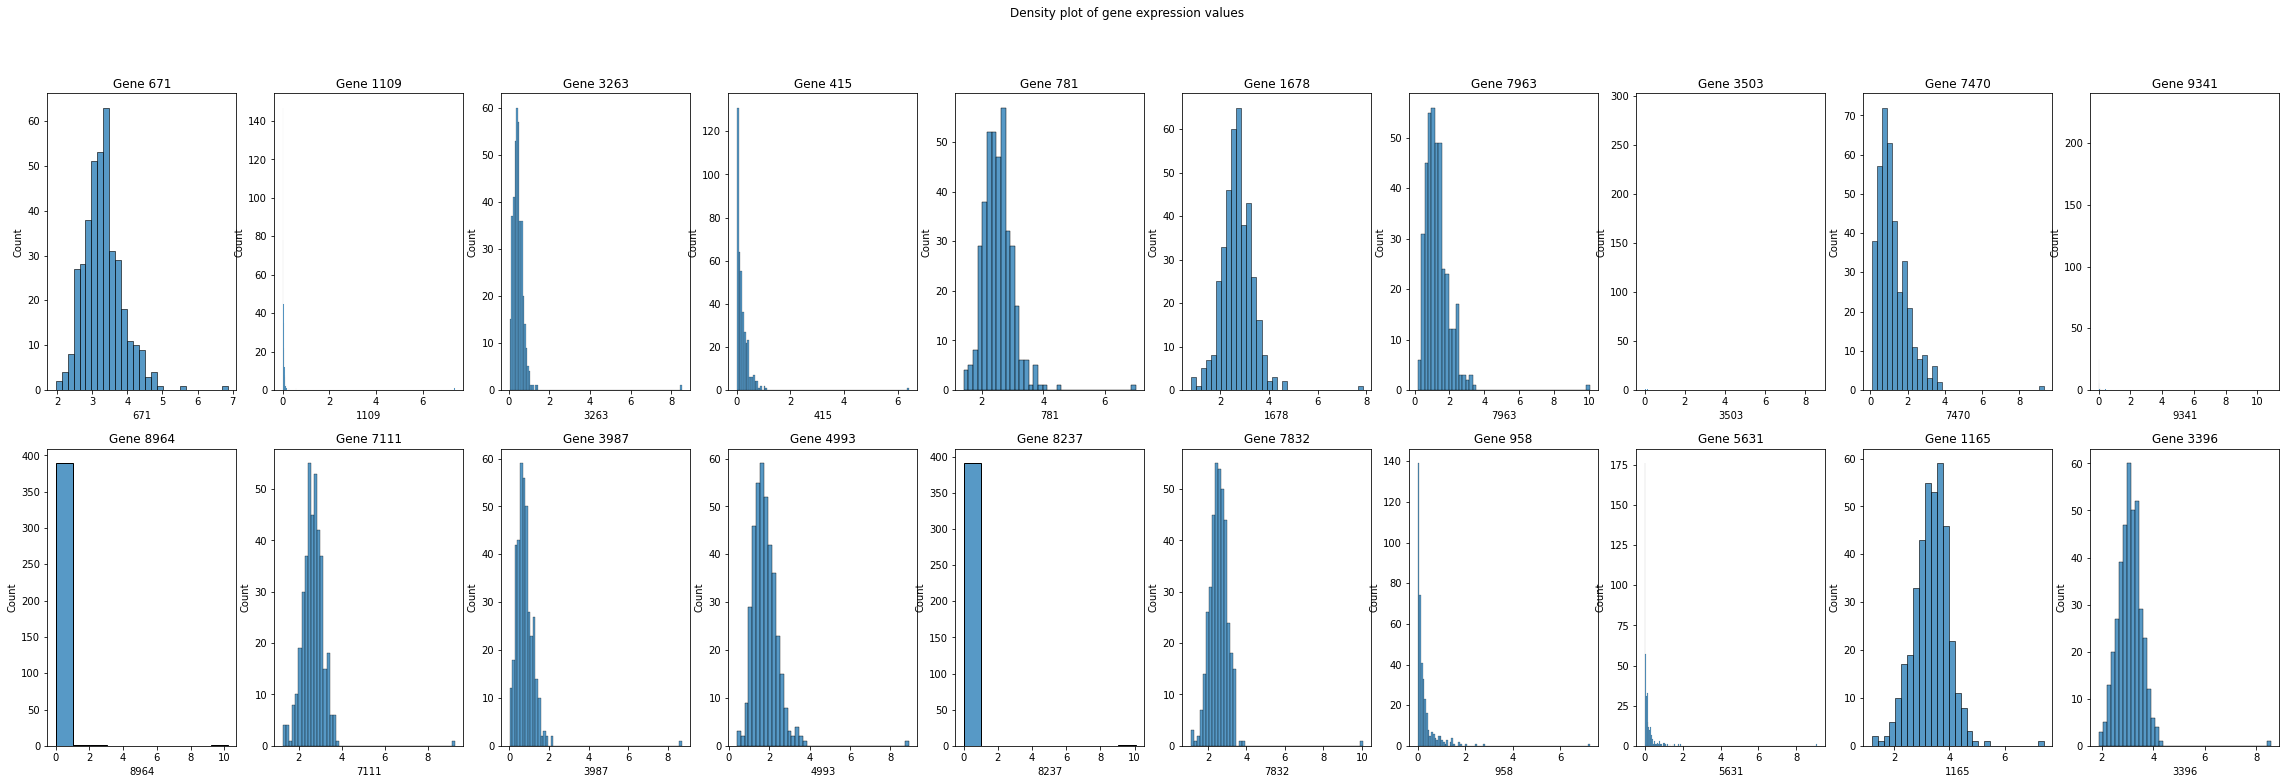

In [9]:
import random
import seaborn as sns

n_samples = 20
idx = random.sample(range(1, 10000), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1

        sns.histplot(ax=ax[i][j], data=np.log(1 + df_counts_tpm.loc[k, :]),
                    palette="Set2"
                   )
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Density plot of gene expression values")
plt.show()

## Gene-level variance

**Distribution of gene expression variance with respect to genes**

the vast majority of the genes are very poorly expressed with a quasi-null variance, we can filter out those genes

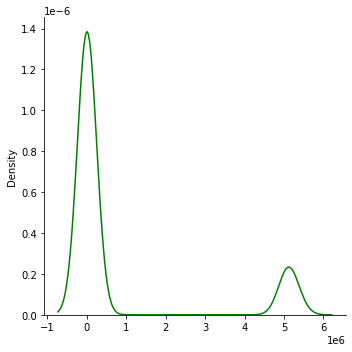

In [10]:
sns.displot(df_counts_tpm.std(axis=1), kind='kde', color='green')

## DE preliminary analysis

While TPM and RPKM/FPKM normalization methods both account for sequencing depth and gene length, RPKM/FPKM are not recommended. The reason is that the normalized count values output by the RPKM/FPKM method are not comparable between samples.

### Sample level QC

A useful initial step in an RNA-seq analysis is often to assess overall similarity between samples:

Which samples are similar to each other, which are different?

Does this fit to the expectation from the experiment’s design?

What are the major sources of variation in the dataset?

**Gene filtering**

In [11]:
df_counts_tpm

,Entrez_ID,MMRF_1021_1_BM,MMRF_1029_1_BM,MMRF_1030_1_BM,MMRF_1031_1_BM,MMRF_1032_1_BM,MMRF_1033_1_BM,MMRF_1038_1_BM,MMRF_1045_1_BM,MMRF_1048_1_BM,...,MMRF_2457_1_BM,MMRF_2473_1_BM,MMRF_2478_1_BM,MMRF_2480_1_BM,MMRF_2490_1_BM,MMRF_2535_1_BM,MMRF_2554_1_BM,MMRF_2557_1_BM,MMRF_2562_1_BM,MMRF_2596_1_BM
0,1,1.911520,19.098200,19.161100,8.469910,8.240950,15.047400,17.934400,5.350370,2.778470,...,0.532119,0.215079,17.883600,14.321200,18.391400,9.655510,54.585300,27.674100,6.491950,0.891303
1,2,1.052220,2.618610,3.666870,0.094211,10.434100,1.229190,0.965247,0.331300,0.387432,...,0.236967,0.759188,5.885150,4.442860,0.086096,2.344650,0.418523,0.588360,2.287260,0.828225
2,3,0.000000,0.000000,0.000000,0.017775,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015320,0.002787,0.000000,0.032605,0.000000,0.000000,0.016019,0.015942,0.000000,0.000000
3,9,1.326820,1.441640,1.095420,1.549710,1.083540,0.619648,1.071690,1.225650,3.198940,...,1.195280,0.641428,1.094000,2.099360,3.063360,2.526920,1.674310,1.575880,3.152830,0.377821
4,10,0.017741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.011568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24123,9570,7.342733,10.476192,9.210365,11.589547,12.129119,10.135862,7.382176,8.645352,12.641991,...,22.082597,7.967950,16.501742,17.255169,47.576376,18.462311,19.976412,22.678195,18.033549,6.759074
24124,9692,1.880706,3.503978,1.633171,4.109536,2.420710,1.080230,2.275507,0.663347,1.676421,...,5.546175,2.208157,1.459650,2.492837,11.472770,2.834858,4.914396,2.332429,4.491953,1.961316
24125,9720,0.821162,1.361006,0.310501,0.768598,0.352493,0.140055,0.049732,0.325077,1.646484,...,38.055475,7.102856,0.389182,0.526326,1.256925,2.059135,1.913760,2.011743,4.216044,10.729138
24126,9768,1.051436,0.598453,1.135515,2.232860,2.469025,0.258161,0.501799,0.347492,2.726785,...,1.896796,1.322460,0.743041,0.524146,15.486935,2.987052,3.563931,1.299004,3.987237,4.207367


**Copy TPM gene expression matrix**.

In [12]:
df_tpm = df_counts_tpm.copy()

**Add a column with the standard deviation**

In [13]:
new_col = df_tpm.drop(['Entrez_ID'], axis=1).std(axis=1)
df_tpm['std'] = new_col
mean_var_thresh = new_col.mean()
df_tpm = df_tpm[df_tpm['std'] > mean_var_thresh]

In [14]:
df_tpm.head()

,Entrez_ID,MMRF_1021_1_BM,MMRF_1029_1_BM,MMRF_1030_1_BM,MMRF_1031_1_BM,MMRF_1032_1_BM,MMRF_1033_1_BM,MMRF_1038_1_BM,MMRF_1045_1_BM,MMRF_1048_1_BM,...,MMRF_2473_1_BM,MMRF_2478_1_BM,MMRF_2480_1_BM,MMRF_2490_1_BM,MMRF_2535_1_BM,MMRF_2554_1_BM,MMRF_2557_1_BM,MMRF_2562_1_BM,MMRF_2596_1_BM,std
0,1,1.91152,19.0982,19.1611,8.46991,8.24095,15.0474,17.9344,5.35037,2.77847,...,0.215079,17.8836,14.3212,18.3914,9.65551,54.5853,27.6741,6.49195,0.891303,15.310110
6,14,21.84910,24.3797,18.1743,27.45720,24.52720,12.2251,16.8904,16.90720,30.54410,...,20.602000,25.3925,28.5125,77.9576,34.41050,50.9399,33.1855,28.78060,20.090100,13.355049
8,16,37.75670,18.2464,32.1920,90.79420,39.39030,21.1760,33.3124,31.87180,55.79410,...,33.058200,41.7947,85.2243,112.5410,62.95530,61.9068,35.3356,46.96560,18.941700,29.339260
24,34,17.35970,27.5726,18.0038,24.11160,17.65110,15.2249,13.6719,14.42070,12.06480,...,20.327600,15.9876,38.1860,36.4694,18.36430,46.8104,31.6899,35.12730,12.596000,13.392638
27,37,89.29550,114.2320,61.8167,60.57360,50.55390,193.3000,68.0084,120.26700,275.35400,...,209.588000,263.3860,291.2980,398.1140,244.86200,380.9760,149.6300,172.35900,95.437900,158.651069


Log2-transformed normalized counts are used to assess similarity between samples using Principal Component Analysis (PCA) and hierarchical clustering. Using log2 transformation, tools aim to moderate the variance across the mean, thereby improving the distances/clustering for these visualization methods.

In [16]:
log_tpm = df_tpm.drop(['Entrez_ID', 'std'], axis=1) 
log_tpm = np.log(1 + log_tpm)
log_tpm

,MMRF_1021_1_BM,MMRF_1029_1_BM,MMRF_1030_1_BM,MMRF_1031_1_BM,MMRF_1032_1_BM,MMRF_1033_1_BM,MMRF_1038_1_BM,MMRF_1045_1_BM,MMRF_1048_1_BM,MMRF_1068_1_BM,...,MMRF_2457_1_BM,MMRF_2473_1_BM,MMRF_2478_1_BM,MMRF_2480_1_BM,MMRF_2490_1_BM,MMRF_2535_1_BM,MMRF_2554_1_BM,MMRF_2557_1_BM,MMRF_2562_1_BM,MMRF_2596_1_BM
0,1.068675,3.000630,3.003755,2.248119,2.223645,2.775547,2.940980,1.848513,1.329319,3.368450,...,0.426652,0.194809,2.938294,2.729237,2.964830,2.366077,4.017919,3.355994,2.013829,0.637266
6,3.128912,3.233950,2.953571,3.348401,3.239745,2.582117,2.884264,2.885203,3.451387,3.372386,...,3.785366,3.072786,3.273080,3.384814,4.368911,3.567008,3.950087,3.531802,3.393857,3.048804
8,3.657304,2.957324,3.502309,4.519549,3.698590,3.099011,3.535507,3.492615,4.039432,3.851396,...,4.995901,3.528071,3.756414,4.456952,4.732164,4.158184,4.141654,3.592798,3.870484,2.992813
24,2.910158,3.352448,2.944639,3.223330,2.925905,2.786547,2.685934,2.735711,2.569922,3.140438,...,4.262495,3.060002,2.832484,3.668320,3.623525,2.963431,3.867243,3.487066,3.587049,2.609776
27,4.503088,4.746947,4.140221,4.120233,3.942628,5.269403,4.234228,4.797995,5.621683,5.740320,...,6.632087,5.349904,5.577410,5.677774,5.989247,5.504770,5.945358,5.014826,5.155365,4.568899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24074,3.118305,2.594737,3.253831,3.908916,3.252234,2.779658,3.061392,3.303682,4.095271,3.997240,...,3.785894,3.262648,3.172727,3.018522,4.489258,4.458804,4.374193,3.488231,3.653844,3.310749
24076,3.312641,3.291510,3.541538,3.094299,3.722266,2.123144,2.234881,3.157427,3.836909,3.878141,...,3.884578,3.108343,3.210324,3.013575,4.347557,4.114056,4.043567,3.896832,4.161280,3.927074
24085,5.222937,6.387753,6.578006,6.653464,6.304132,6.437440,5.985369,6.521266,6.280687,6.829079,...,6.718766,5.788841,6.138364,5.925941,7.106168,6.980557,7.530080,7.011421,7.466736,6.962929
24105,4.313167,4.838364,4.105625,4.608075,4.719287,3.315968,3.863955,4.001155,4.800787,4.265749,...,4.689025,4.224355,3.849202,4.113470,5.019767,5.190043,5.366358,4.620012,5.378079,4.511640


Randomly select a few patients and plot them.

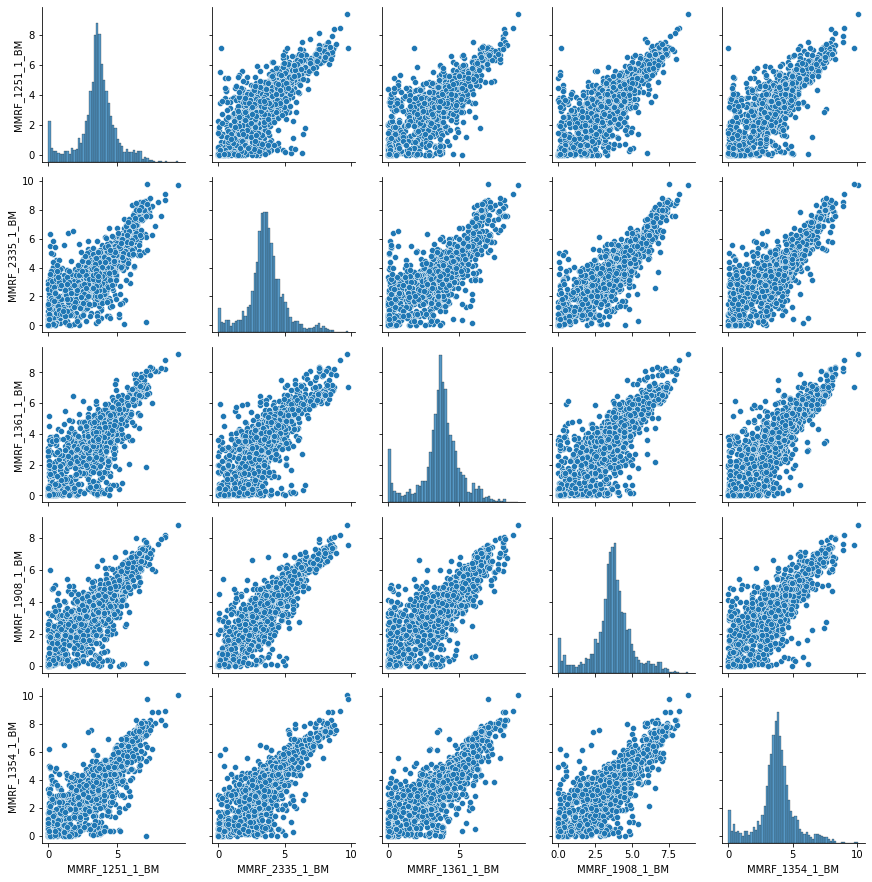

In [17]:
random_patients = random.sample(list(log_tpm.columns), 5)
g = sns.PairGrid(log_tpm.loc[:, random_patients])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

Sample-level QC allows us to see how well our replicates cluster together, as well as, observe whether our experimental condition represents the major source of variation in the data. Performing sample-level QC can also identify any sample outliers, which may need to be explored to determine whether they need to be removed prior to DE analysis.

### PCA for visualizing clusters

Let's visualize the distirbution of the standard deviations of the genese, post filtering

We have 2733 genes left in the dataset


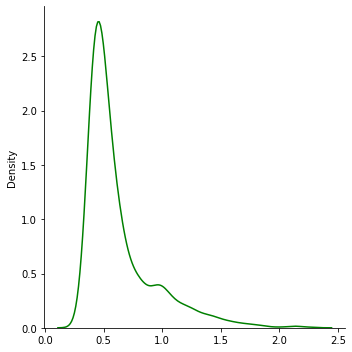

In [18]:
print("We have {} genes left in the dataset".format(log_tpm.shape[0]))
sns.displot(log_tpm.std(axis=1), kind='kde', color='green')

select subset of common patients

mapping

In [19]:
id_to_gender = {k: df_clin[df_clin['Patient'] == k]['D_Gender'].values[0] for k in log_tpm.columns}
id_to_flag = {k: df_clin[df_clin['Patient'] == k]['HR_FLAG'].values[0] for k in log_tpm.columns}
id_to_iss = {k: df_clin[df_clin['Patient'] == k]['D_ISS'].values[0] for k in log_tpm.columns}
id_to_pfs = {k: df_clin[df_clin['Patient'] == k]['D_OS_FLAG'].values[0] for k in log_tpm.columns}

In [20]:
X = log_tpm.values.T
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

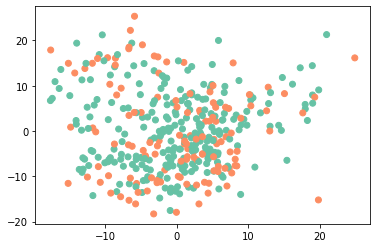

In [21]:
# Unique category labels: 'D', 'F', 'G', ...

#dict_temp = id_to_os
#dict_temp = id_to_iss
dict_temp = id_to_flag

color_labels = np.unique(list(dict_temp.values()))
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# array of colors
colors = pd.Series(dict_temp.values())

# Plot
plt.scatter(X_pca[:, 3],
            X_pca[:, 2], 
            c=colors.map(color_map), 
            )

plt.show()

PCA not spearating GE data well: https://www.biostars.org/p/324128/

### Prepare the data for Differential Expression with DESeq2 (in R)

**Remember**: For the training, we only care about patients that have RNA-seq data available

#### Overlapping Genes

Patients of the validation set might come from different cohorts and we don't have the guarantee that the genes of these patients are the one in the training set: For the sake of robustness, we only care about **overlapping genes**.

Hg19 is used as the reference.

Gene IDs are in the ensemble Gene ID's format. https://m.ensembl.org/info/genome/stable_ids/index.html

We can do this with the 'mygene' package as shown in https://www.biostars.org/p/92574/ or https://nbviewer.org/gist/newgene/6771106


In [22]:
### Overlapping genes
df_overlap = pd.read_csv("data/gene_expression/overlappingEntrezIds.csv")

print("Overlapping genes in all cohort studies{}".format(df_overlap))

Overlapping genes in all cohort studies       entrezID
0           100
1          1000
2         10000
3         10001
4         10003
...         ...
13732      9991
13733      9992
13734      9993
13735      9994
13736      9997

[13737 rows x 1 columns]


In [23]:
import mygene

mg = mygene.MyGeneInfo()
geneList = list(df_counts['GENE_ID'].values)
geneSyms = mg.querymany(geneList , scopes='symbols,ensembl.gene', fields='entrezgene', species='human')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

**mapping ensemble ID gene symbols to entrez_ID**

In [24]:
ens_to_entrez = {}
entrez_to_ens = {}
overlapping_entrez = [str(x) for x in df_overlap['entrezID'].values]
for g in geneSyms:
    if "notfound" in g:
        if g["notfound"] == True:
            ens_to_entrez[g['query']] = "NOT_FOUND"
    else:
        ens_to_entrez[g["query"]] = g['_id']
        entrez_to_ens[g['_id']] = g["query"]

**Getting the list of overlapping genes found in count data gene expression matrix**

In [25]:
overlapping_entrez = [str(x) for x in df_overlap['entrezID'].values]
final_entrez = []
for k, v in ens_to_entrez.items():
    if v in overlapping_entrez:
        final_entrez.append(v)
        
print("We selected a subset of {}".format(len(final_entrez)))

We selected a subset of 13702


**Final gene expression matrix pre-processing before DE**

In [27]:
# 1. First 
df_exp = df_counts.copy()

# 2. Select overlapping genes
gene_cols = [entrez_to_ens[g] for g in final_entrez]
df_exp = df_exp.loc[df_exp['GENE_ID'].isin(gene_cols)]

# 3. Change ID to Entrez_ID
df_exp['GENE_ID'] = [ens_to_entrez[k] for k in df_exp['GENE_ID']]

# 4. Convert to integer
df_exp = df_exp.astype({col: int for col in df_exp.columns[1:]})

df_exp

,GENE_ID,MMRF_1021_1_BM,MMRF_1029_1_BM,MMRF_1030_1_BM,MMRF_1031_1_BM,MMRF_1032_1_BM,MMRF_1033_1_BM,MMRF_1038_1_BM,MMRF_1045_1_BM,MMRF_1048_1_BM,...,MMRF_2457_1_BM,MMRF_2473_1_BM,MMRF_2478_1_BM,MMRF_2480_1_BM,MMRF_2490_1_BM,MMRF_2535_1_BM,MMRF_2554_1_BM,MMRF_2557_1_BM,MMRF_2562_1_BM,MMRF_2596_1_BM
173,9086,0,2283,0,1888,1735,1450,2037,0,0,...,4,10,5653,3566,2,0,31,3033,275,4
214,22829,0,13,61,0,198,2,0,0,0,...,0,0,23,1387,0,0,1,717,45,1
220,8653,24,11905,6,1808,3886,9843,4354,17,9,...,12,6,22347,13865,7,2,271,12922,859,61
274,90665,0,0,0,77,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
299,7544,0,1489,1,713,658,779,654,0,0,...,1,0,1698,1812,0,0,19,1155,105,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57989,338440,21,1807,598,317,232,1403,486,1335,1441,...,2932,742,974,4597,1691,803,6682,3727,685,809
57990,3265,291,927,1028,610,289,557,813,612,814,...,1255,622,921,724,1242,960,1112,1028,761,1468
57993,115399,89,802,314,216,80,361,269,203,179,...,953,477,431,362,1145,501,485,241,260,361
57994,22862,11137,22523,10891,7290,6942,12436,14405,11739,9981,...,34663,15017,39820,48263,17935,13332,22666,27636,15754,12815


Create a metadata matrix for the DESeq2 analysis. This matrix should contain ..;

In [28]:
metadata_df = pd.DataFrame(columns = ["Patient", "D_Age", "D_ISS", "HR_FLAG"])
for i, patient_id in enumerate(df_exp.columns[1:]):
    temp_df = df_clin[df_clin["Patient"] == patient_id]
    metadata_df.loc[i] = [patient_id, temp_df["D_Age"].values[0], temp_df["D_ISS"].values[0], temp_df["HR_FLAG"].values[0]]

metadata_df

,Patient,D_Age,D_ISS,HR_FLAG
0,MMRF_1021_1_BM,54,1.0,FALSE
1,MMRF_1029_1_BM,46,1.0,FALSE
2,MMRF_1030_1_BM,65,1.0,FALSE
3,MMRF_1031_1_BM,62,1.0,FALSE
4,MMRF_1032_1_BM,76,2.0,FALSE
...,...,...,...,...
386,MMRF_2535_1_BM,46,3.0,TRUE
387,MMRF_2554_1_BM,65,1.0,TRUE
388,MMRF_2557_1_BM,83,3.0,TRUE
389,MMRF_2562_1_BM,66,2.0,TRUE


missing values in D_ISS.

In [29]:
metadata_df["D_ISS"] = metadata_df["D_ISS"].fillna(2)

Save data

In [30]:
df_exp.to_csv("data/gene_expression/differential_expression/count_gene_expression.csv", index=False)
metadata_df.to_csv("data/gene_expression/differential_expression/metadata.csv", index=False)

In [31]:
y = pd.read_csv('data/gene_expression/differential_expression/metadata.csv', index_col=False)
y

,Patient,D_Age,D_ISS,HR_FLAG
0,MMRF_1021_1_BM,54,1.0,False
1,MMRF_1029_1_BM,46,1.0,False
2,MMRF_1030_1_BM,65,1.0,False
3,MMRF_1031_1_BM,62,1.0,False
4,MMRF_1032_1_BM,76,2.0,False
...,...,...,...,...
386,MMRF_2535_1_BM,46,3.0,True
387,MMRF_2554_1_BM,65,1.0,True
388,MMRF_2557_1_BM,83,3.0,True
389,MMRF_2562_1_BM,66,2.0,True


In [32]:
df_exp

,GENE_ID,MMRF_1021_1_BM,MMRF_1029_1_BM,MMRF_1030_1_BM,MMRF_1031_1_BM,MMRF_1032_1_BM,MMRF_1033_1_BM,MMRF_1038_1_BM,MMRF_1045_1_BM,MMRF_1048_1_BM,...,MMRF_2457_1_BM,MMRF_2473_1_BM,MMRF_2478_1_BM,MMRF_2480_1_BM,MMRF_2490_1_BM,MMRF_2535_1_BM,MMRF_2554_1_BM,MMRF_2557_1_BM,MMRF_2562_1_BM,MMRF_2596_1_BM
173,9086,0,2283,0,1888,1735,1450,2037,0,0,...,4,10,5653,3566,2,0,31,3033,275,4
214,22829,0,13,61,0,198,2,0,0,0,...,0,0,23,1387,0,0,1,717,45,1
220,8653,24,11905,6,1808,3886,9843,4354,17,9,...,12,6,22347,13865,7,2,271,12922,859,61
274,90665,0,0,0,77,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
299,7544,0,1489,1,713,658,779,654,0,0,...,1,0,1698,1812,0,0,19,1155,105,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57989,338440,21,1807,598,317,232,1403,486,1335,1441,...,2932,742,974,4597,1691,803,6682,3727,685,809
57990,3265,291,927,1028,610,289,557,813,612,814,...,1255,622,921,724,1242,960,1112,1028,761,1468
57993,115399,89,802,314,216,80,361,269,203,179,...,953,477,431,362,1145,501,485,241,260,361
57994,22862,11137,22523,10891,7290,6942,12436,14405,11739,9981,...,34663,15017,39820,48263,17935,13332,22666,27636,15754,12815


### Differential Analysis results

In [41]:
#import gzip

#with open('data/gene_expression/differential_expression/DE_results.csv', 'rb') as fd:
#    gzip_fd = gzip.GzipFile(fileobj=fd)
#    de_results = pd.read_csv(gzip_fd)
    
de_results = pd.read_csv('data/gene_expression/differential_expression/DE_results.csv',
                         index_col=False,
                        encoding='ISO-8859–1')

de_results = de_results.rename(columns = {'Unnamed: 0':'Entrez_ID'})
de_results

,Entrez_ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,6279,2862.326213,2.422364,0.262265,9.236314,2.551354e-20,3.494334e-16
1,6286,88.605540,2.332819,0.267333,8.726274,2.632012e-18,1.802402e-14
2,8993,97.077713,1.870030,0.220338,8.487099,2.118592e-17,9.672081e-14
3,383,86.920107,1.710288,0.202374,8.451114,2.885352e-17,9.879446e-14
4,7075,9.848379,1.815154,0.217090,8.361284,6.203919e-17,1.699377e-13
...,...,...,...,...,...,...,...
13691,9880,1196.466604,0.000012,0.050980,0.000230,9.998168e-01,9.999818e-01
13692,90693,538.654579,0.000010,0.056871,0.000179,9.998573e-01,9.999818e-01
13693,2169,1.733445,-0.000023,0.220740,-0.000104,9.999168e-01,9.999818e-01
13694,84280,912.687477,0.000002,0.048913,0.000032,9.999745e-01,9.999818e-01


Select gene that passed the significance test

In [42]:
de_results[de_results['pvalue']<=0.005]

,Entrez_ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,6279,2862.326213,2.422364,0.262265,9.236314,2.551354e-20,3.494334e-16
1,6286,88.605540,2.332819,0.267333,8.726274,2.632012e-18,1.802402e-14
2,8993,97.077713,1.870030,0.220338,8.487099,2.118592e-17,9.672081e-14
3,383,86.920107,1.710288,0.202374,8.451114,2.885352e-17,9.879446e-14
4,7075,9.848379,1.815154,0.217090,8.361284,6.203919e-17,1.699377e-13
...,...,...,...,...,...,...,...
1299,51184,825.961025,0.144456,0.051392,2.810877,4.940663e-03,5.205179e-02
1300,3780,3.081783,-0.581292,0.206825,-2.810549,4.945713e-03,5.206493e-02
1301,8614,51.622172,1.037653,0.369282,2.809917,4.955429e-03,5.212716e-02
1302,30819,150.537365,-0.457437,0.162911,-2.807901,4.986561e-03,5.240227e-02


In [43]:
de_results['LogFoldChange'] = np.abs(de_results['log2FoldChange'])

,Entrez_ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,LogFoldChange
0,6279,2862.326213,2.422364,0.262265,9.236314,2.551354e-20,3.494334e-16,2.422364
1,6286,88.605540,2.332819,0.267333,8.726274,2.632012e-18,1.802402e-14,2.332819
2,8993,97.077713,1.870030,0.220338,8.487099,2.118592e-17,9.672081e-14,1.870030
3,383,86.920107,1.710288,0.202374,8.451114,2.885352e-17,9.879446e-14,1.710288
4,7075,9.848379,1.815154,0.217090,8.361284,6.203919e-17,1.699377e-13,1.815154
...,...,...,...,...,...,...,...,...
13691,9880,1196.466604,0.000012,0.050980,0.000230,9.998168e-01,9.999818e-01,0.000012
13692,90693,538.654579,0.000010,0.056871,0.000179,9.998573e-01,9.999818e-01,0.000010
13693,2169,1.733445,-0.000023,0.220740,-0.000104,9.999168e-01,9.999818e-01,0.000023
13694,84280,912.687477,0.000002,0.048913,0.000032,9.999745e-01,9.999818e-01,0.000002


Select genes according to LFC magnitutde

In [743]:
k = 100

top_genes = de_results.nlargest(k, 'LogFoldChange')['Entrez_ID'].values[:k]

top_genes

array([  4103,   4995, 221662,  56892, 139135,   3852,   2045,  90865,
         1284,  94031,   1282,   3776,  90737,  90161,   6781, 116159,
         2838,   2220,  10631,   6279, 139065,  80177,   7850, 221395,
        26577,   4071,   6947,  10562,  25984,   6286,  57126,    999,
        79953,  10642,  22899,  64321,  23742,   2261,   3934,  64094,
         6401,   3577, 133584,  54873,  84701,   6283,  10331,   4317,
         1909, 199675,   6376,   7450,  51705,   1404,   1281,  64123,
       375567,   1053, 147381,   4837, 116441,   3240,   2528,    249,
         7122,   6496,   4881,  54345,  54097,  56729,    552,   4057,
        57381,    762,   8993,   1003,    932,  83639,   4070,  84856,
         3579,   7075,   1776,    660, 169611,  54511,   6280, 200879,
        10690,    187,   3791,  79616,   9235,   8796,   5617, 144501,
         2691,   4100,   8807,  90187])

### Adding genes from the litterature (EMC-92 and UMAS_70 sigatures) !!

In [744]:
with open('data/priori_knowledge/emc92-genes.txt') as f:
    lines1 = f.readlines()[1:]
with open('data/priori_knowledge/emc92-genes.txt') as f:
    lines2 = f.readlines()[1:]

xli = []
for l in lines1:
    gene = l.split(' ')[3]
    xli.append(gene)
for l in lines2:
    gene = l.split(' ')[3]
    xli.append(gene)
xli

['SLC30A7',
 'AK2',
 'SYF2',
 'S100A6',
 'NUF2',
 'DARS2',
 'ARPC5',
 'DTL',
 'ANGEL2',
 'LBR',
 'TARBP1',
 'GGPS1',
 'LTBP1',
 'FAM49A',
 'MCM6',
 'ACVR2A',
 'GRB14',
 'ITGA6',
 'DHRS9',
 '0,0525',
 'SPATS2L',
 'BCS1L',
 'SFMBT1',
 'ARL8B',
 'POLQ',
 'MCM2',
 'CCRL1',
 'SEC62',
 'GABRA4',
 'PGM2',
 'NCAPG',
 'FGFR3',
 'SEPT11',
 'AIMP1',
 'CENPE',
 'IL7R',
 'DHFR',
 'SAR1B',
 'PCDHB7',
 'ATP6V0E1',
 'MCM3',
 'TUBB',
 'TUBB',
 'MARCKS',
 'SLC17A5',
 'NCUBE1',
 'SUN1',
 'DNAJB9',
 'Unknown',
 'RAB2A',
 'TRAM1',
 'ZNF252',
 'HNRNPK',
 'MRPL41',
 'ZWINT',
 'Unknown',
 'FANCF',
 'EHBP1L1',
 'C11orf85',
 'PPP2R1B',
 'ROBO3',
 'Unknown',
 'C1S',
 'ESPL1',
 'ITM2B',
 'ZBTB25',
 'NPC2',
 'ATPBD4',
 'C15orf38',
 'FANCI',
 'SMG1',
 'DYNLRB2',
 'TMEM97',
 'SPAG5',
 'TOP2A',
 'BIRC5',
 'C18orf10',
 'TSPAN16',
 'RPS28',
 'RPS11',
 'NOP56',
 'FTL',
 'CDH22',
 'DONSON',
 'PFKL',
 'ST13',
 'DUX4',
 'RPS4X',
 'KIF4A',
 'HMGN5',
 'HMGB3',
 'MAGEA6',
 'SLC30A7',
 'AK2',
 'SYF2',
 'S100A6',
 'NUF2',
 'DAR

In [745]:
geneEntrez = mg.querymany(xli, scopes='symbol', fields='entrezgene', species='human')
signature_genes = [int(d['_id']) for d in geneEntrez if 'notfound' not in d]

signature_genes

querying 1-184...done.
Finished.
78 input query terms found dup hits:
	[('SLC30A7', 2), ('AK2', 2), ('SYF2', 2), ('S100A6', 2), ('NUF2', 2), ('DARS2', 2), ('ARPC5', 2), ('
26 input query terms found no hit:
	['FAM49A', '0,0525', 'CCRL1', 'SEPT11', 'NCUBE1', 'Unknown', 'ZNF252', 'Unknown', 'C11orf85', 'Unkno
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


[148867,
 204,
 25949,
 6277,
 83540,
 55157,
 10092,
 51514,
 90806,
 3930,
 6894,
 9453,
 4052,
 4175,
 92,
 2888,
 3655,
 10170,
 26010,
 617,
 51460,
 55207,
 10721,
 4171,
 7095,
 2557,
 55276,
 64151,
 2261,
 9255,
 1062,
 3575,
 1719,
 51128,
 56129,
 8992,
 4172,
 203068,
 203068,
 4082,
 26503,
 23353,
 4189,
 5862,
 23471,
 3190,
 64975,
 11130,
 2188,
 254102,
 5519,
 64221,
 716,
 9700,
 9445,
 7597,
 10577,
 55215,
 23049,
 83657,
 27346,
 10615,
 7153,
 332,
 26526,
 6234,
 6205,
 10528,
 2512,
 64405,
 29980,
 5211,
 6767,
 100288687,
 6191,
 24137,
 79366,
 3149,
 4105,
 148867,
 204,
 25949,
 6277,
 83540,
 55157,
 10092,
 51514,
 90806,
 3930,
 6894,
 9453,
 4052,
 4175,
 92,
 2888,
 3655,
 10170,
 26010,
 617,
 51460,
 55207,
 10721,
 4171,
 7095,
 2557,
 55276,
 64151,
 2261,
 9255,
 1062,
 3575,
 1719,
 51128,
 56129,
 8992,
 4172,
 203068,
 203068,
 4082,
 26503,
 23353,
 4189,
 5862,
 23471,
 3190,
 64975,
 11130,
 2188,
 254102,
 5519,
 64221,
 716,
 9700,
 9445

**Signature genes that we have in the TPM dataset**

In [746]:
signature_genes = list(set(signature_genes) & set(df_counts_tpm['Entrez_ID'].values))

print("We found {} genes from the signatures in the TPM dataset".format(len(signature_genes)))

We found 76 genes from the signatures in the TPM dataset


**Train a simple Classifier**

In [1117]:
# 1. Select genes according to logfold changes
keep_genes = list(top_genes) #+ signature_genes
print("Total number of genes in the dataset: {}".format(len(keep_genes)))
df_train = df_counts_tpm.loc[df_counts_tpm['Entrez_ID'].isin(keep_genes), :]

# 2. Select all genes
#all_genes = de_results[de_results['pvalue']<=0.005]['Entrez_ID']
#df_train = df_counts_tpm.loc[df_counts_tpm['Entrez_ID'].isin(all_genes), :]

# Map an integer index to each gene in the features
idx_to_gene = {i: int(df_train.iloc[i]['Entrez_ID']) for i in range(df_train.shape[0])}
#gene_to_idx = {df_train.iloc[i]['Entrez_ID']: i for i n range(df_train.shape[0])}

df_train = df_train.drop(['Entrez_ID'], axis=1)
df_train = np.log(1 + df_train)

df_train.shape

Total number of genes in the dataset: 100


(100, 391)

**Merging with clinical data**

In [1118]:
df_train = df_train.T
df_train["D_ISS"] = df_clin["D_ISS"].values
df_train["D_Age"] = df_clin["D_Age"].values
df_train["D_Gender"] = df_clin["D_Gender"].values
df_train

,129,171,380,453,527,653,707,711,753,889,...,15598,16247,16377,16437,16695,16716,18186,D_ISS,D_Age,D_Gender
MMRF_1021_1_BM,0.000000,0.053368,0.000000,0.000000,0.057709,0.025493,0.004144,0.011033,0.000000,0.068363,...,0.033104,0.001690,0.058106,0.331706,0.000000,0.090021,0.000881,1.0,54,Female
MMRF_1029_1_BM,0.004593,0.003917,0.000000,0.000000,0.000000,0.031520,0.257527,0.008981,0.039499,0.008924,...,0.005694,0.005040,0.030142,0.002050,0.000000,0.000000,0.007067,1.0,46,Male
MMRF_1030_1_BM,0.000000,0.038246,0.000000,0.004680,0.000000,0.028691,0.005489,0.005518,0.000000,0.039806,...,0.000000,0.005636,0.013920,0.000000,0.000000,0.000000,0.000000,1.0,65,Female
MMRF_1031_1_BM,0.009380,0.165301,1.130476,0.040598,0.043536,0.301606,0.088938,0.014824,0.147359,0.175759,...,0.006553,0.005079,0.109900,0.334920,0.000000,0.000000,0.000000,1.0,62,Male
MMRF_1032_1_BM,0.000000,0.080194,0.000000,0.009556,0.050177,0.120615,0.087571,0.005658,0.031732,0.005065,...,0.000000,0.003860,0.164244,0.005791,0.000000,0.000000,0.000000,2.0,76,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMRF_2535_1_BM,0.465509,1.932619,0.000000,0.575306,1.466269,2.046160,0.005802,0.385671,1.085568,0.952225,...,0.097226,0.059814,2.208887,0.060720,0.192923,0.034876,0.011463,3.0,46,Female
MMRF_2554_1_BM,0.026195,0.113807,0.024981,0.005588,0.000000,0.009670,0.003280,0.094414,0.027951,0.129478,...,0.035442,0.008297,0.008343,0.121280,0.063570,0.000000,0.070036,1.0,65,Male
MMRF_2557_1_BM,0.000000,0.012709,0.000000,0.000000,0.000000,0.018813,0.010717,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.016508,0.078801,0.000000,0.000000,0.012584,3.0,83,Male
MMRF_2562_1_BM,0.011833,0.024991,0.010149,0.005865,0.000000,0.020035,0.000000,0.003447,0.009933,0.007567,...,0.000000,0.000000,0.038903,0.335561,0.000000,0.000000,0.000000,2.0,66,Male


**Gender => Binary**

In [1119]:
replace_dict = {"Male": 1, "Female": 0}
df_train = df_train.replace(replace_dict)

**Binning age feature**

In [1120]:
bins = [0, 35, 50, 60, 70, 80, 200]
labels_bins = [1, 2, 3, 4, 5, 6]

df_train["D_Age"] = pd.cut(df_train["D_Age"],
                          bins=bins,
                          labels=labels_bins
                         )

**Missing value imputation for D_ISS**

In [1121]:
df_train[['D_ISS']] = df_train[['D_ISS']].fillna(2)

**Prepare data for the model**

In [1141]:
X = df_train.values
replace_dict = {'TRUE': 1, 'FALSE': 0}

# HR_FLAG labels
y_hr = df_clin['HR_FLAG'].replace(replace_dict).values
# D_OS labels
y_os = df_clin['D_OS'].values
y_os_clf = df_clin['D_OS_FLAG'].values
# D_PFS labels
y_pfs = df_clin['D_PFS'].values
y_pfs_clf = df_clin['D_PFS_FLAG'].values

X.shape, y_hr.shape

((391, 103), (391,))

Split data

In [1142]:
#X_train, X_test, y_train_hr, y_test_hr, y_train_os, _, y_train_pfs, _, \
#        y_train_os_clf, _, y_train_pfs_clf, _    = train_test_split(X,
#                                                                    y_hr,
#                                                                    y_os,
#                                                                    y_pfs,
#                                                                    y_os_clf,
#                                                                    y_pfs_clf,
#                                                                    test_size=0.2)

X_train, X_test, y_train_hr, y_test_hr, y_train_os, _, y_train_pfs, _ = train_test_split(X,
                                                                    y_hr,
                                                                    y_os,
                                                                    y_pfs,
                                                                    test_size=0.2)                                                                                           

X_train.shape, X_test.shape

((312, 103), (79, 103))

**Classifiers**

In [1143]:
#clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf = RandomForestClassifier().fit(X_train, y_train_hr)
#clf_os = RandomForestClassifier().fit(X_train, y_train_os_clf)
#clf_pfs = RandomForestClassifier().fit(X_train, y_train_pfs_clf)

**Regressors**

CENSORED patients shoud be added to the training set of the regressors. No cap.

In [1144]:
regr_os = RandomForestRegressor().fit(X_train, y_train_os)
regr_pfs = RandomForestRegressor().fit(X_train, y_train_pfs)

Inference

In [1145]:
# Classification
y_pred_hr = clf.predict(X_test)
#y_pred_os_clf = clf_os.predict(X_test)
#y_pred_os_pfs = clf_pfs.predict(X_test)

# Regressor D_OS
y_pred_os = regr_os.predict(X_test)
y_pred_os = y_pred_os <= 18*30

# Regressor D_PFS
y_pred_pfs = regr_pfs.predict(X_test)
y_pred_pfs = y_pred_pfs <= 18*30

# prediction for regression
y_pred_regr = np.logical_or(y_pred_os, y_pred_pfs).astype(int)

#y_pred = y_pred_hr + y_pred_os_clf + y_pred_os_pfs + y_pred_regr
#y_pred = (y_pred > 2).astype(int)
y_pred = np.logical_or(y_pred_hr, y_pred_regr).astype(int)

In [1146]:
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [1147]:
acc = balanced_accuracy_score(y_pred_hr, y_test_hr)
fpr, tpr, thresh = roc_curve(y_pred_hr, y_test_hr)
auc = metrics.auc(fpr, tpr)
#precision, recall = precision_score(y_pred, y_test_hr), recall_score(y_pred, y_test_hr)
#f1 = f1_score(y_pred, y_test_hr)
#conf_mat = confusion_matrix(y_pred, y_test_hr)

#f1, precision, recall, 
acc, auc

(0.7755281690140845, 0.7755281690140845)

#### Selecting genes with Feature importance (RF)

In [1155]:
#FEATURES = ['Gene_'+ str(idx_to_gene[i]) for i in range(X.shape[1])]
#importance_df = pd.DataFrame(clf.feature_importances_, columns=["Importance"], index=FEATURES).sort_values(['Importance'], ascending = True)
#importance_plot = importance_df.iloc[-100:]  
#importance_plot.iloc[-20:].plot(kind='barh',
#                                title ="Feature importances (Train set)",
#                                grid=True,
#                                figsize=(24, 16))

In [1156]:
#rf_genes = [int(g.split('_')[1]) for g in importance_df.index][:100]

**Overlap of RF genes and DE top100 genes**

In [1157]:
#intersect_genes = list(set(rf_genes) & set(top_genes))
#intersect_genes

**Clinical data**

In [1158]:
#df_clin[(df_clin["D_PFS"] < 18*30) | (df_clin["D_OS"] < 18*30)]

In [1159]:
#with open("data/gene_expression/differential_expression/DE_genes.txt", "w") as f:
#    for s in keep_genes:
#        f.write(str(s) +"\n")